# Grid Cell Phase Coding 

"Phases are in radians, coordinates are in [m] and time base is [ms]. The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value"

After changing parameters in the second cell, from the top menu click 'Cell' -> 'Run All' then scroll through

(TODO: add firing map (#spikes/time), variance as lightness in meanphasemap (pi), variance weighting, amount of spikes vs. correlation, temporal separation of spikes vs. correlation, radial distribution of prediction variance, population vector prediction,
low variance phase map?)

(note whether coordinates in numpy [-y,x] or Cartesian [x,y])

In [228]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
from scipy.stats import pearsonr
import pycircstat
from scipy import ndimage

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

In [425]:
dir = 'datasets/1/'

#Spatial or temporal analysis
analysis_type = 'temporal'

## XYspkT

XYspkT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

XYspkT is float values, can be converted to integer with np.round(scaled_XY) as the coarse spatial analysis from the adjacency matrix only results in integer movement predictions

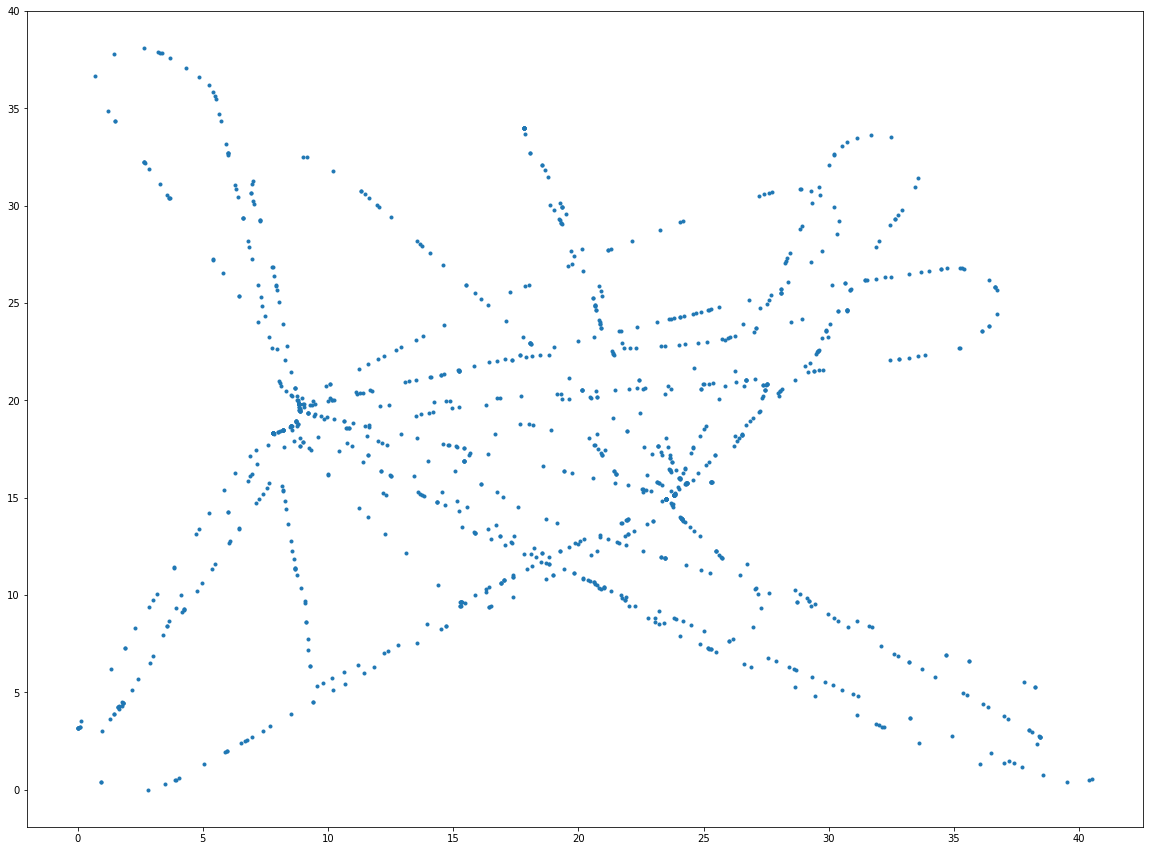

In [426]:
XYspkT = np.loadtxt(dir+'XYspkT.csv',delimiter=',')

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

plt.plot(scaled_XY[:,0],scaled_XY[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [427]:
spkT = np.loadtxt(dir+'spkT.csv',delimiter=',')
print(spkT)
spkT.shape

[ 27466.  29501.  36602. ... 288400. 295600. 297440.]


(1178,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at the moment of spike

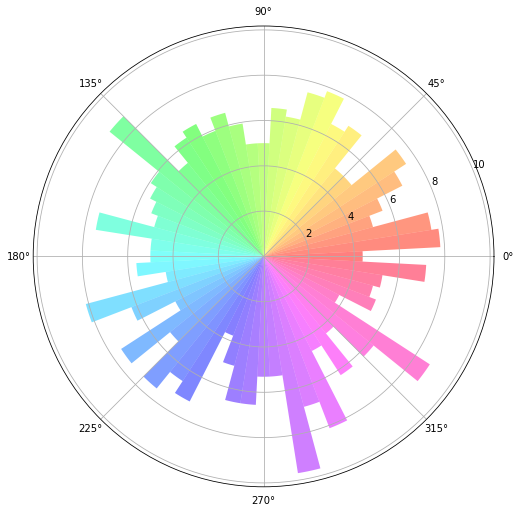

In [444]:
phase = np.loadtxt(dir+'Phase.csv',delimiter=',')
#phase = np.random.rand(spkT.size)*6.28
scaled_phase = phase-3.14

phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

TODO:

-(time based meanphasemap of first half, traj from second)

-average internode distance

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


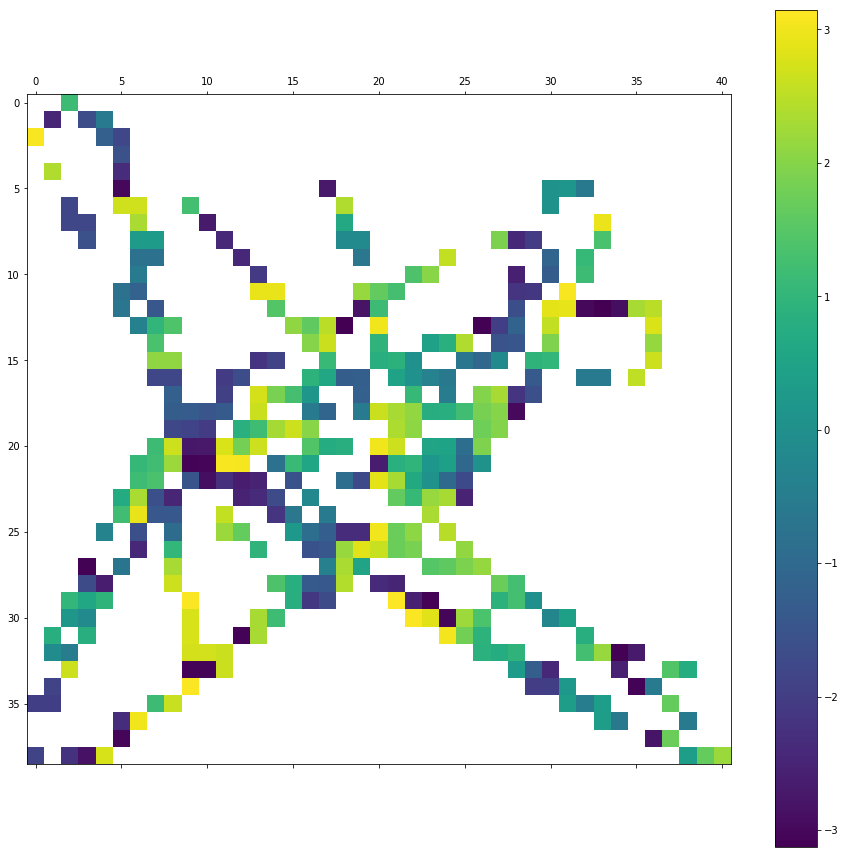

In [432]:
def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = pycircstat.mean(np.asarray(phases))

    #Rotate the dataframe 90 CCW
    mpm = pd.DataFrame.from_dict(mpm_dict).T
    phase_df = mpm.reindex(index=mpm.index[::-1])-3.14
    
    #(Uniform) Smoothing algorithm
    #Replaces each value with circular mean of (inclusive) neighbouring 3x3 matrix
    np_dfp = np.pad(phase_df.as_matrix(), 1, 'constant', constant_values=np.nan)
    a = np.zeros((np_dfp.shape[0], np_dfp.shape[1]))

    for i in range(len(np_dfp)-2):
        for j in range(len(np_dfp[i])-2):
            arr = np_dfp[i:i+3,j:j+3]
            if not np.isnan(arr[1,1]):
                n_arr = arr[~np.isnan(arr)]
                avg = pycircstat.mean(n_arr)
                a[i+1,j+1] = avg

    a[a==0]=np.nan
    a = a[1:-1,1:-1]-3.14
    phase_df = pd.DataFrame(a)
    
    return phase_df

mpm_arr = np.column_stack((XYspkT,phase))
phase_df = mean_phase_map(mpm_arr,2)

arena_size = phase_df.shape


plt.matshow(phase_df)

#To-do: reflect radians in bar
plt.colorbar()

## MeanVarMap

MeanVarMap the map of gamma phases. A given value at the n-th row and m-th column represents the variance of spike phases all spikes) within that area during the entire navigation. 

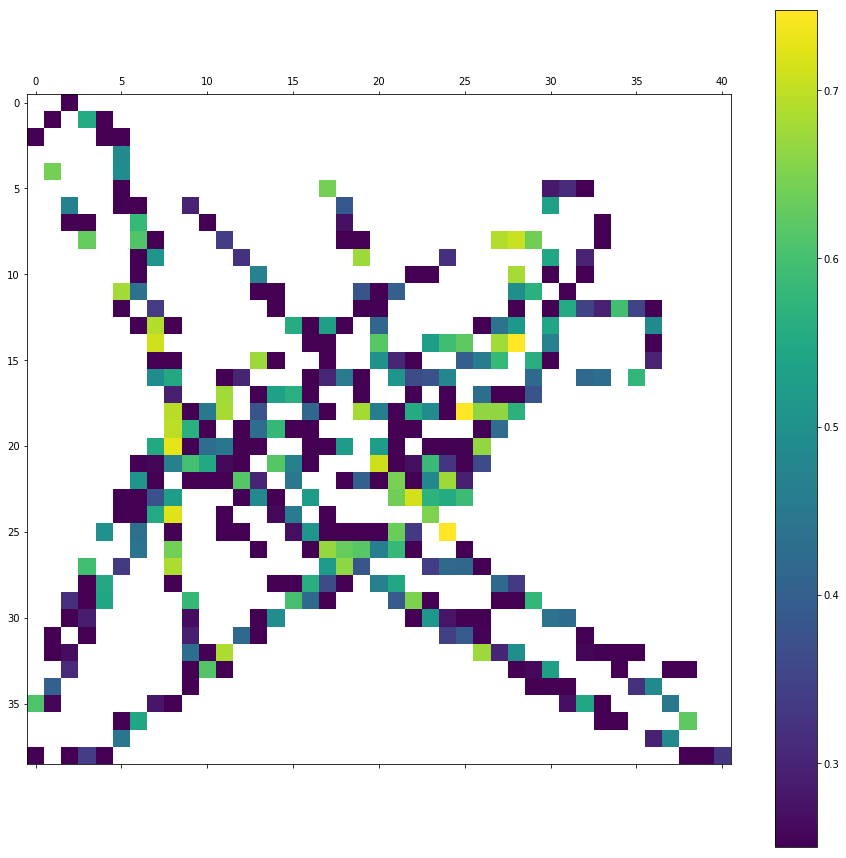

In [433]:
def mean_var_map(arr, bin_size):
    mvm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mvm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mvm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mvm_dict[ybin][xbin] = (pycircstat.var(np.asarray(phases))+0.5)/2

    #Rotate the dataframe 90 CCW
    mvm = pd.DataFrame.from_dict(mvm_dict).T
    var_df = mvm.reindex(index=mvm.index[::-1])
    return var_df

vm_arr = np.column_stack((XYspkT, phase))
var_df = mean_var_map(vm_arr, 2)


plt.matshow(var_df)
#rgb = hsv_to_rgb(hsv)


#To-do: reflect radians in bar
plt.colorbar()

## xyPos
xyPos is the trajectory traveled by the avatar. Each row is an X-Y data pair in [m] sampled in every ms. It is the biggest file because of the density of points. You can down-sample it to make it more manageable.

[[30.8703  33.9996 ]
 [30.8703  33.9996 ]
 [30.8703  33.9996 ]
 ...
 [52.412   35.49039]
 [52.354   35.38029]
 [52.295   35.27064]]


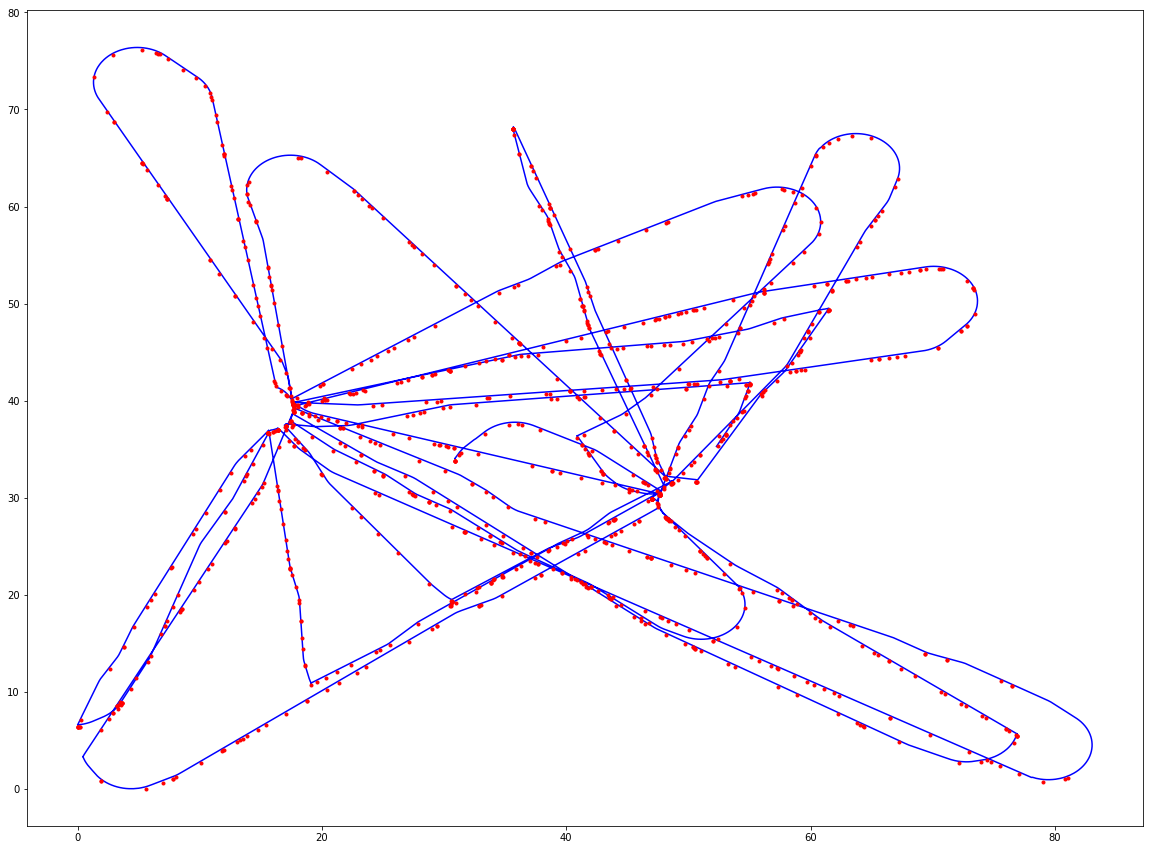

In [445]:
xyPos = np.loadtxt(dir+'xyPos.csv',delimiter=',')[::25]
xyPos[:,1]-= xyPos[:,1].min()
xyPos[:,0]-= xyPos[:,0].min()
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=6)

## MeanPhaseMap DataFrame


In [446]:
#A padded phase map for use in edge-cases for extracting the 5x5 adjacency matrix below
padded_phase_map = np.pad(phase_df,pad_width=2,mode='constant',constant_values=np.nan)
padded_phase_df = pd.DataFrame(data=padded_phase_map)
padded_phase_df.shape

(43, 45)

### Adjacency Function

Adjacent spikes returns the best matching MeanPhaseMap location for the next 6 spikes phases, adjacent matrix returns a 5x5 array to analyze a region of space adjacent to a target location within the MeanPhaseMap, then finds
the x and y difference from the center to cell to the cell with the cloest matching value (of phase).

example return array:

       [ 3.0844,     nan, -1.5684,     nan,     nan],

       [ 3.0844,     nan,     nan, -1.6837, -1.5763],
       
       [    nan,     nan,     nan,     nan, -1.5088],
       
       [-2.8458,     nan,     nan,     nan, -2.5082],
       
       [-2.8458,     nan,     nan,     nan,     nan]

In [447]:
def adjacent_matrix(cell, phase):
    """Determines change vector from central cell to cell
    nearest in value in 5x5 IN FORM **[X,Y]** """        
    x = int(cell[0])
    y = int(cell[1])
    y_size = arena_size[0]-1
    a = padded_phase_df.iloc[y_size-y:y_size-y+5,x:x+5]

    try:
        nearest = np.nanargmin(np.abs(a-phase))
        loc = [(nearest%5)-2,2-(nearest//5)]

        #Rounding down to the nearest bin, adding 0.5 to point to center of bin        
        xp = x+loc[0]+0.5
        yp = y+loc[1]+0.5    
        return[xp - cell[0],yp - cell[1]]

    except:
        return [0,0]    


def adjacent_spikes(spikes, phase):
    """Get location of spike with most similar phase"""
    y_size = arena_size[0] - 1
    phases = []
    vars = []
    for i in spikes:
        x = int(i[0])
        y = int(i[1])
        phases.append(phase_df.iloc[y_size - y, x])
        vars.append(var_df.iloc[y_size - y, x])
    phases = np.asarray(phases)
    vars = np.asarray(vars)
    diffs = np.abs(phases - phase)*vars
    
    try:
        #nearest = np.nanargmin(diffs)
        nearest = np.nanargmin(np.abs(phases - phase))
    except:
        nearest = 0

    try:
        #Rounding down to the nearest bin, adding 0.5 to point to center of bin
        x = int(spikes[nearest][0])+0.5 
        y = int(spikes[nearest][1])+0.5
        return [x - spikes[0, 0], y - spikes[0, 1]]

    except:
        return [0.0, 0.0]
    
    
#Tests:
#print(adjacent_matrix([3,0.5],-1.5))
#adjacent_spikes(combined[10:16,1:3],combined[10,4])

## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [448]:
unsorted = np.column_stack((spkT,scaled_XY,scaled_phase))
sorted = unsorted[unsorted[:,0].argsort()]

#Calculate movement magnitudes
xdif = np.append(sorted[1:,1],0)-np.append(sorted[:-1,1],0)
ydif = np.append(sorted[1:,2],0)-np.append(sorted[:-1,2],0)

#Drop rows with movements below threshold
move_thresh = 0.01

raw = np.column_stack((sorted,xdif,ydif))
print(raw)
movement  = raw[np.any(abs(raw[:,4:]) >= move_thresh, axis=1)]

#Recalculate movement magnitudes
xdif = np.append(movement[1:,1],0)-np.append(movement[:-1,1],0)
ydif = np.append(movement[1:,2],0)-np.append(movement[:-1,2],0)
next_phase = np.insert(movement[1:,3],-1, 0)

combined = np.column_stack((movement[:,:4],next_phase,xdif,ydif))
print(combined)

[[    16.             15.43365        16.8938         -0.1855586
       0.              0.        ]
 [   127.             15.43365        16.8938          2.11555607
       0.              0.        ]
 [   133.             15.43365        16.8938          1.6205565
       0.              0.        ]
 ...
 [298520.             26.4205         18.04311         0.11258542
      -0.08           -0.14914   ]
 [298580.             26.3405         17.89397        -2.80283062
      -0.1275         -0.2394    ]
 [298690.             26.213          17.65457        -1.38042128
       0.              0.        ]]
[[   275.             15.43365        16.8938     ...      0.68245397
       0.18125         0.31235   ]
 [   863.             15.6149         17.20615    ...     -1.17940049
       0.0604          0.09215   ]
 [   907.             15.6753         17.2983     ...      2.35000813
       0.9843          0.983465  ]
 ...
 [298420.             26.5295         18.24738    ...      0.11258542


In [449]:
# Spatial Analysis
if analysis_type == 'spatial':
    predicted = [adjacent_matrix([i[1],i[2]],i[4]) for i in combined]
    predicted_movement = np.asarray(predicted)

# Temporal Analysis    
if analysis_type == 'temporal':
    diff = int(len(spkT)/200)
    if diff<5:
        diff=5
    predicted = [adjacent_spikes(combined[i:i+diff,1:3],combined[i,4]) for i in range(len(combined))]
    predicted_movement = np.asarray(predicted)
    
all=np.column_stack((combined,predicted_movement))
df = pd.DataFrame(data=all, columns=['Time','X','Y','Phase','Next Phase','Xdif','Ydif','Xdif Predicted', 'Ydif Predicted'])

df

,Time,X,Y,Phase,Next Phase,Xdif,Ydif,Xdif Predicted,Ydif Predicted
0,275.0,15.433650,16.893800,1.886428,0.682454,0.181250,0.312350,2.066350,1.606200
1,863.0,15.614900,17.206150,0.682454,-1.179400,0.060400,0.092150,1.885100,1.293850
2,907.0,15.675300,17.298300,-1.179400,2.350008,0.984300,0.983465,0.824700,1.201700
3,1495.0,16.659600,18.281765,2.350008,-2.931404,1.004150,0.481885,0.840400,0.218235
4,1950.0,17.663750,18.763650,-2.931404,-2.429947,0.370250,0.010150,-0.163750,-0.263650
5,2099.0,18.034000,18.773800,-2.429947,-0.377397,0.142650,-0.016700,4.466000,-2.273800
6,2157.0,18.176650,18.757100,-0.377397,-0.781344,0.733800,-0.272300,4.323350,-2.257100
7,2473.0,18.910450,18.484800,-0.781344,-0.948938,2.139300,-1.058855,3.589550,-1.984800
8,3432.0,21.049750,17.425945,-0.948938,-2.201935,1.676900,-1.278345,1.450250,-0.925945
9,4263.0,22.726650,16.147600,-2.201935,2.605556,0.415850,-0.328100,0.773350,-0.647600


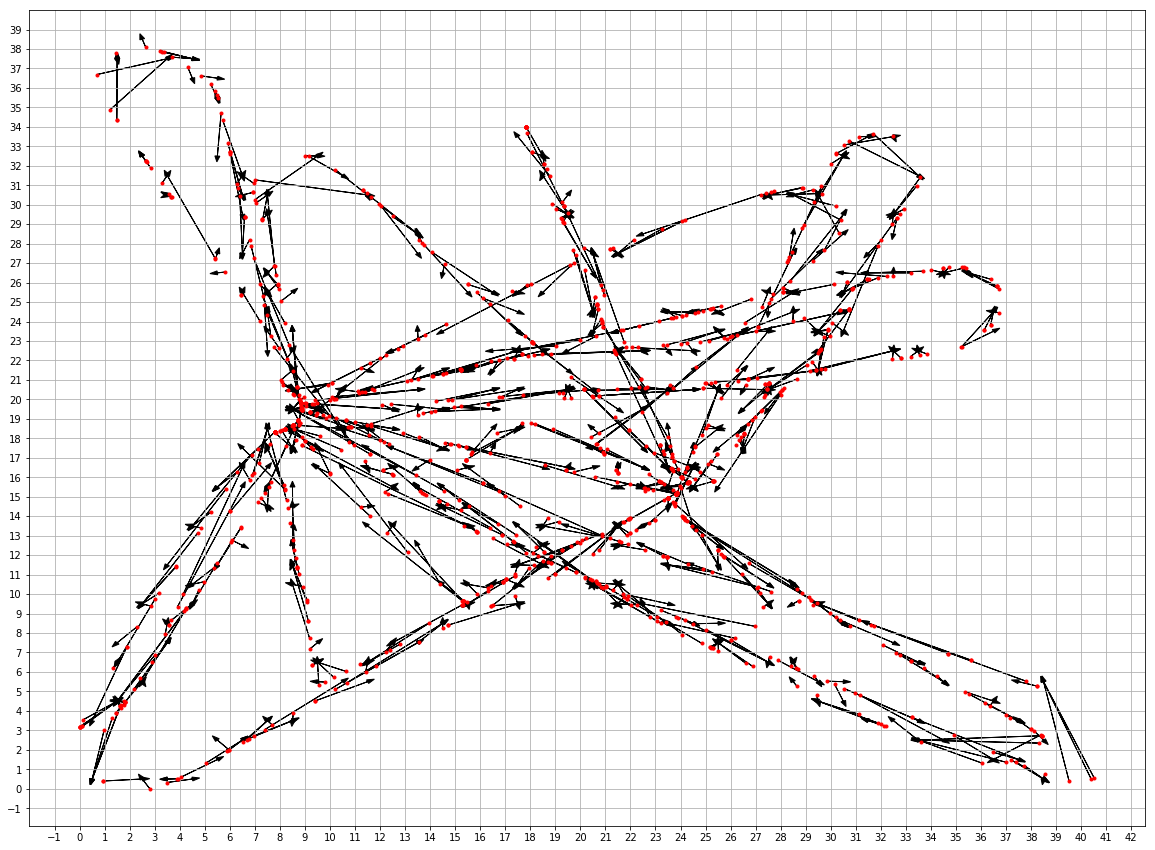

In [450]:
plt.rcParams['figure.figsize'] = [20, 15]
ax = plt.subplot()
#plt.plot(xyPos[:,0]/2, xyPos[:,1]/2, color='b')
plt.plot(scaled_XY[:,0], scaled_XY[:,1], '.', color='r', markersize=6)
for index, row in df.iterrows():
    # if (row['Xdif Predicted']>0) or (row['Ydif Predicted']>0):
    plt.arrow(row['X'], row['Y'], row['Xdif Predicted'], row['Ydif Predicted'],
                head_width=0.2, color='black')

ax.set_xticks(np.arange(scaled_XY[:,0].min()-1,scaled_XY[:,0].max()+2))
ax.set_yticks(np.arange(scaled_XY[:,1].min()-1,scaled_XY[:,1].max()+1))
ax.grid()

## Vector Angles

Calculates the angle between each movements observed and predicted vector angle to store in a list for use
in the correlation figures

In [451]:
#Determines the angle between the horizontal axis (+1 x, +0 y) and the current vector, returns [observed,predicted]
def abs_vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1],all[i+1,2]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            obs_angles.append(360+np.degrees(atan))
        else:
            obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i,1]+all[i,7],all[i,2]+all[i,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            pred_angles.append(360+np.degrees(atan))
        else:
            pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))


In [452]:
angles = np.asarray(abs_vector_angles(all))

print('Linear r correlation : ' + str(pearsonr(angles[:,0],angles[:,1])[0]))
print('Circular r correlation: ' + str(pycircstat.corrcc(np.radians(angles[:,0]),np.radians(angles[:,1]))))

Linear r correlation : 0.5769455355203131
Circular r correlation: 0.5705748026930778


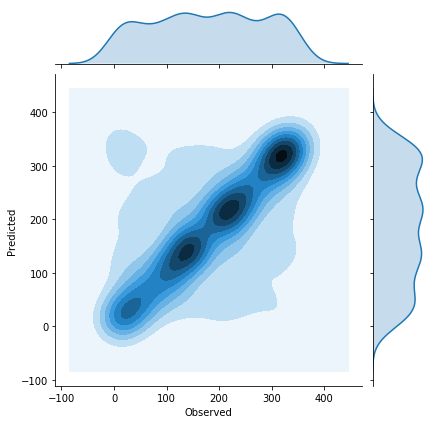

In [442]:
dfa = pd.DataFrame(angles, columns=['Observed', 'Predicted'])
sns.jointplot(x='Observed',y='Predicted',data=dfa,kind='kde');

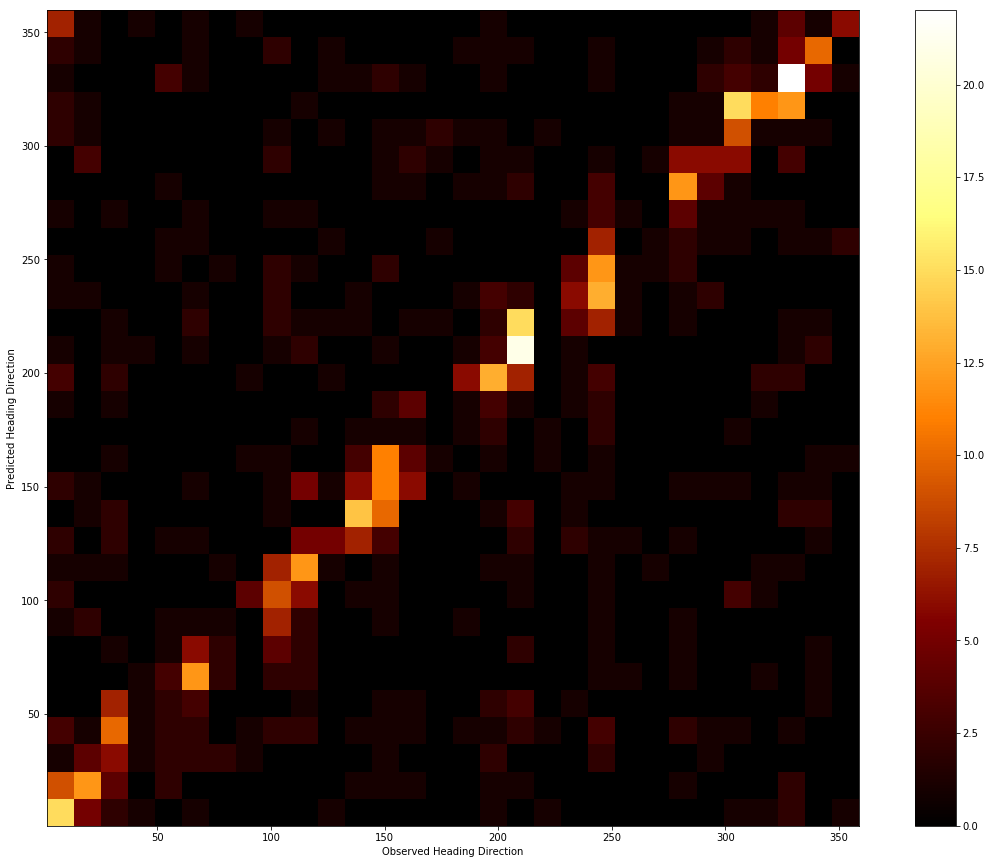

In [443]:
heatmap, xedges, yedges = np.histogram2d(angles[:,0], angles[:,1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='afmhot')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

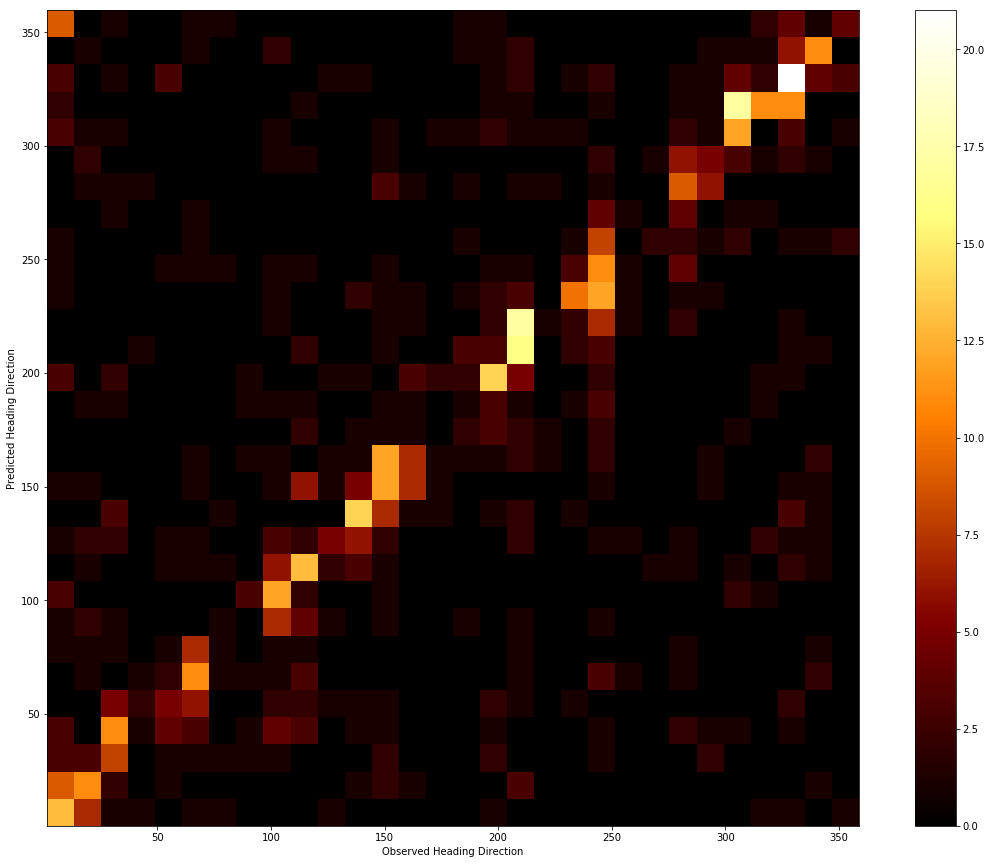

In [453]:
heatmap2, xedges, yedges = np.histogram2d(angles[:,0], angles[:,1], bins=30)
extent2 = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap2.T, extent=extent, origin='lower',cmap='afmhot')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

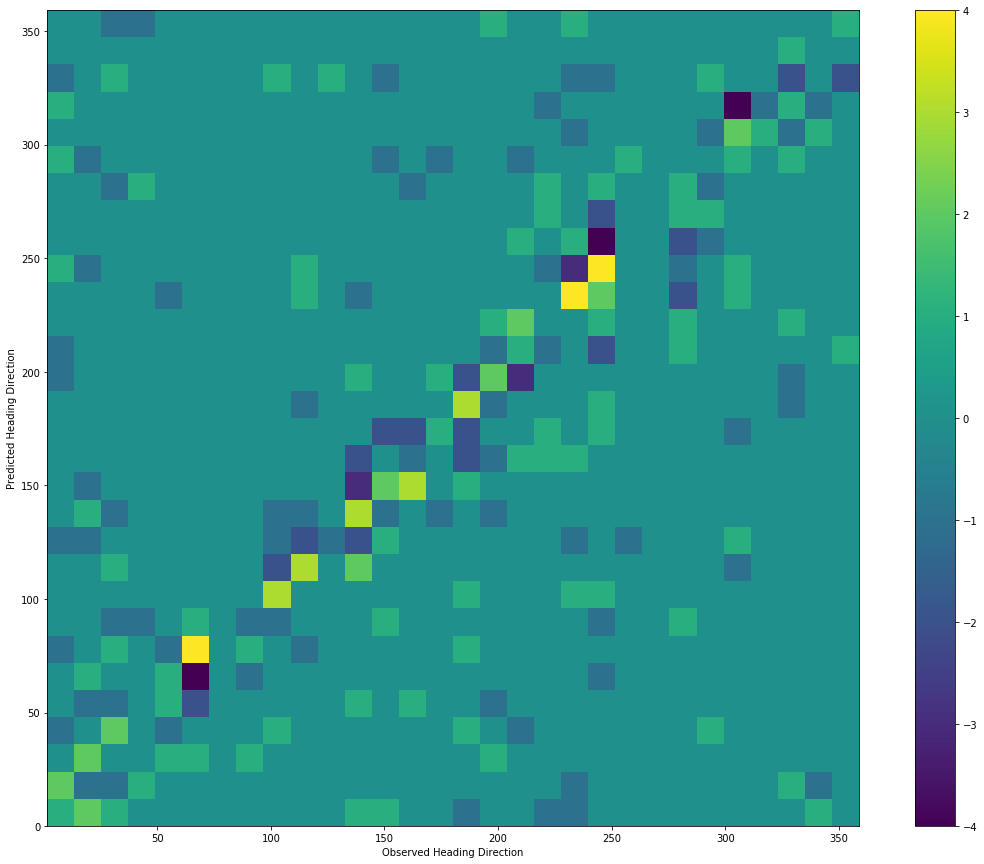

In [88]:
test = heatmap2.T-heatmap.T

plt.clf()
plt.imshow(test, extent=extent, origin='lower')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

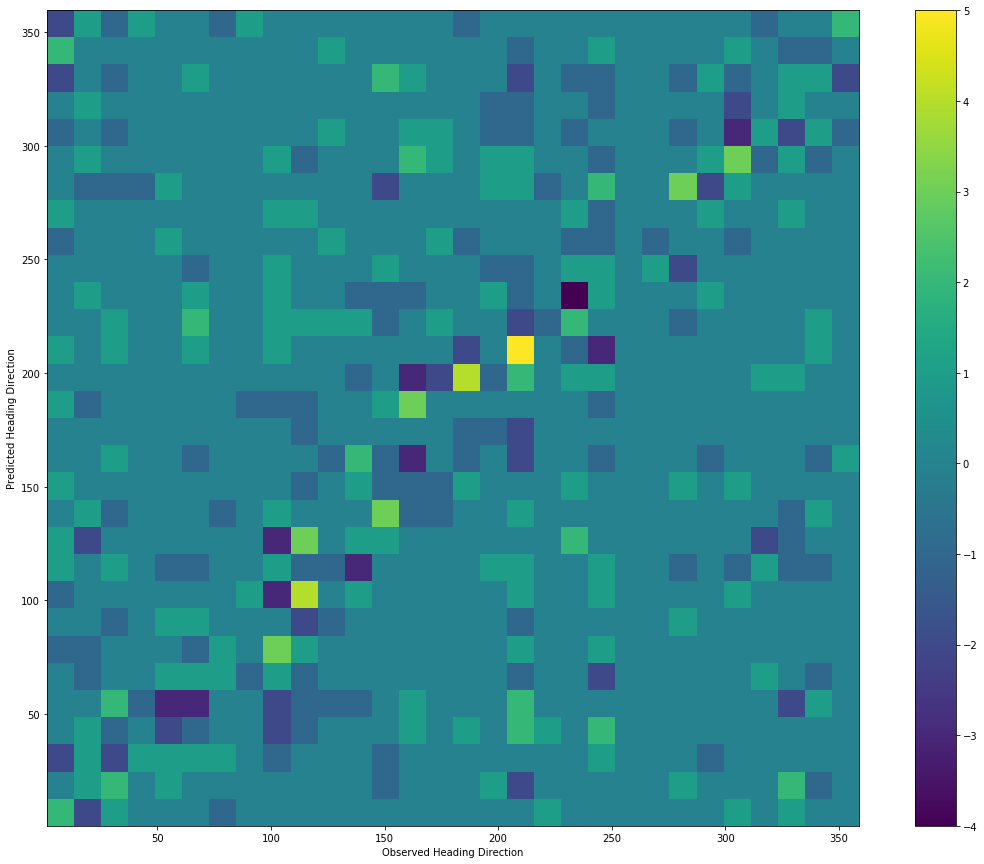

In [456]:
test = heatmap.T-heatmap2.T

plt.clf()
plt.imshow(test, extent=extent, origin='lower')
plt.ylabel('Predicted Heading Direction')
plt.xlabel('Observed Heading Direction')
plt.colorbar()
plt.show()

## Testing Area

Sandbox for developing new features

In [ ]:
diff = np.sort(angles[:,0]-angles[:,1])

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(diff.min(),diff.max()+6,6))

inds = [np.where(diff<i)[0][-1] for i in np.arange(diff.min()+6,diff.max()+6,6)] #vectorize operation?
b = np.split(diff,inds)
radii = np.array([i.size for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

In [ ]:
def firing_rate_map(arr,bin_size):
    fr_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        fr_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            times = []
            fr_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    times.append(spike[2]/1000)   
            
#             # Group spikes by differences > 1000 ms
#             split_inds = []
#             times = np.unique(np.sort(times)) # Cases of same time?
#             for i in range(len(times)):
#                 try:
#                     if times[i+1]-times[i]>1:
#                         split_inds.append(i+1)
#                 except:
#                     pass
#             spike_groups = np.split(times,np.unique(split_inds))
            
#             # Find firing rate of each group by dividing the total count/duration
#             rates = []
#             for i in spike_groups:
#                 try:
#                     a = len(i)
#                     b = max(i)-min(i)
#                     if b == 0:
#                         b = 1
#                     rates.append(a/b)
#                 except:
#                     pass
            
            fr_dict[ybin][xbin] = times
            
    return fr_dict


fr_arr = np.column_stack((XYspkT,spkT))
fr_dict = firing_rate_map(fr_arr,2)


#Rotate the dataframe 90 CCW
frm = pd.DataFrame.from_dict(fr_dict).T
fr_df = frm.reindex(index=frm.index[::-1])


plt.matshow(fr_df)


#To-do: reflect radians in bar
plt.colorbar()